In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import sys  
  
# The path you want to add  
path_to_add = r'C:\Users\elorberb\PycharmProjects\BGU projects\Advanced_NLP\DeltaPredictor'  
  
# Add the directory to sys.path  
sys.path.insert(0, path_to_add)


In [5]:
df = pd.read_csv("../data/test.csv")
df.drop('meta.success', axis=1, inplace=True)
# Iterate over the DataFrame and print the text of each record  
# for index, row in df.head(15).iterrows():  
#     print(f"Record {index}:\n{row['text']}, \nlabel: {row['label']}")  

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1972 non-null   object
 1   label   1972 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 30.9+ KB


In [12]:
from src.prompts import template_zero_shot_only_comment
from src.langchain_utils import run_chain
from langchain_openai import AzureChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd  
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tqdm import tqdm
  

load_dotenv()
deployments = []
zero_shot_template = template_zero_shot_only_comment()
llm = AzureChatOpenAI(azure_deployment='gpt-4-32k')
prompt_template = PromptTemplate(input_variables=["comment"], template=zero_shot_template)
chain = LLMChain(llm=llm, prompt=prompt_template)

# Create a copy of the original dataframe to store predictions  
df_copy = df.copy()  
n = 100 # number of records to evaluate
# Add a new column for predicted labels in the copy  
df_copy['predicted_label'] = None  
  
# Predict the labels for the first 10 rows  
for i, row in tqdm(df.head(n).iterrows()):  
    comment = row['text']  
    resp = chain(comment)
    pred = int(resp['text'])  # Make sure the response from the model is correctly converted to an integer label  
    df_copy.at[i, 'predicted_label'] = pred  
    
# Calculate accuracy, precision, and recall for the first 10 records  
true_labels = df_copy['label'].head(n).tolist()  
predicted_labels = df_copy['predicted_label'].head(n).tolist()  
  
# Calculate metrics  
accuracy = accuracy_score(true_labels, predicted_labels)  
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)  # Added zero_division=0 to handle divide by zero  
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)  # Added zero_division=0 to handle divide by zero  
  
print(f"Accuracy: {accuracy}")  
print(f"Precision: {precision}")  
print(f"Recall: {recall}") 

100it [00:42,  2.35it/s]

Accuracy: 0.57
Precision: 0.5511413307430791
Recall: 0.57


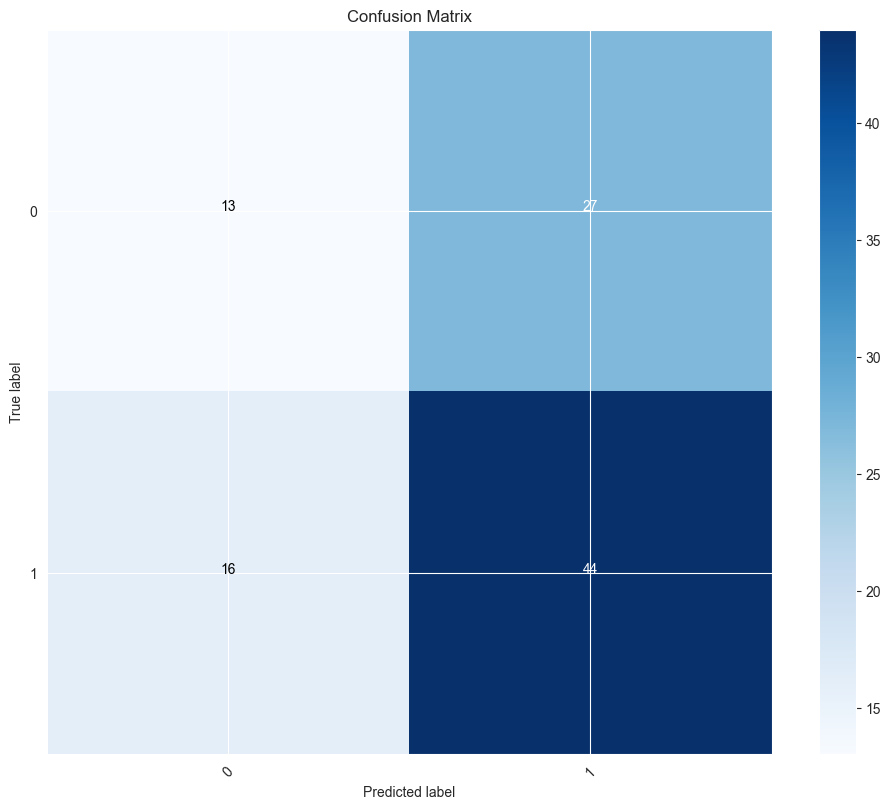

              precision    recall  f1-score   support

           0       0.45      0.33      0.38        40
           1       0.62      0.73      0.67        60

    accuracy                           0.57       100
   macro avg       0.53      0.53      0.52       100
weighted avg       0.55      0.57      0.55       100


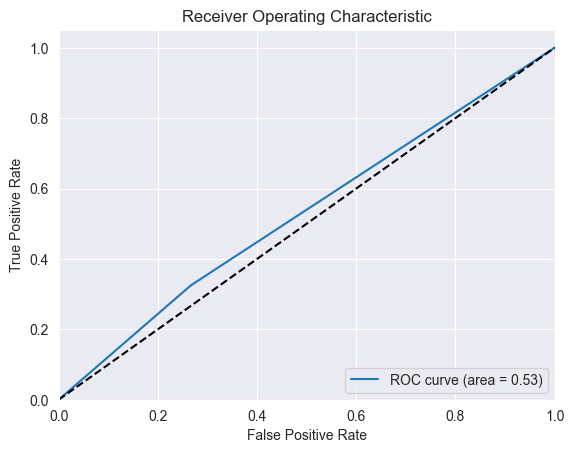

In [21]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import roc_curve, auc, RocCurveDisplay  
from sklearn.preprocessing import label_binarize  
from sklearn.metrics import roc_auc_score  
import numpy as np  
import itertools  

  
# ... (Your existing code for running predictions and calculating accuracy, precision, and recall)  
  
# Assuming your classes are string or integer  
unique_classes = df_copy['label'].unique()  
# Sort the classes if necessary  
unique_classes.sort()  
n_classes = len(unique_classes)  
  
# Convert unique_classes to an array of strings for plotting  
class_names = unique_classes.astype(str)  
  
# Calculate confusion matrix  
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_classes)  
  
# Classification report using the converted class names  
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)  
  
# Plot confusion matrix  
plt.figure(figsize=(10, 8))  
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)  
plt.title('Confusion Matrix')  
plt.colorbar()  
tick_marks = np.arange(n_classes)  
plt.xticks(tick_marks, class_names, rotation=45)  
plt.yticks(tick_marks, class_names)  
  
# Adding numbers to the confusion matrix  
thresh = conf_matrix.max() / 2.  
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):  
    plt.text(j, i, conf_matrix[i, j],  
             horizontalalignment="center",  
             color="white" if conf_matrix[i, j] > thresh else "black")  
  
plt.tight_layout()  
plt.ylabel('True label')  
plt.xlabel('Predicted label')  
plt.show()  
  
# Print classification report  
print(class_report)

# Binary classification ROC curve  
fpr, tpr, thresholds = roc_curve(true_labels_int, predicted_labels_int)  
roc_auc = auc(fpr, tpr)  
  
# Plot ROC curve  
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)  
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Receiver Operating Characteristic')  
plt.legend(loc="lower right")  
plt.show()  